### Notebook to configure model

In [4]:
import time
import math
import copy

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context(context="talk")

import torch
import torch.nn as nn
import tensorflow as tf
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils import data


/anaconda3/envs/mlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
# Hyperparameter

QUERY_SIZE = 10
EMBEDDING_SIZE = 100

# HIDDEN_SIZE = 512
# ATTENTION_SIZE = 64

LEARNING_RATE = 1e-3
BATCH_SIZE = 500

VOCAB_SIZE = 5
NUM_CLASSES = 2

# Data-specific

READ_LENGTH = 10

GENOME_START = 0
GENOME_END = 100

GENOME_LENGTH = GENOME_END - GENOME_START + 1   # 205438
CONTEXT_SIZE = GENOME_LENGTH

ref_names = ["class", "ref", "sequence"]


In [33]:
def load_ref_data(file_name, sample_ratio= 1, n_class=2, names=ref_names):
    
    csv_file = pd.read_csv(file_name, names=ref_names)
    shuffle_csv = csv_file.sample(frac=sample_ratio).reset_index()
#     x = pd.Series(shuffle_csv["sequence"])
    x = list(shuffle_csv["sequence"])
#     ref = pd.Series(shuffle_csv["ref"])
    ref = list(shuffle_csv["ref"])
    y = pd.Series(shuffle_csv["class"])
    y = to_one_hot(y, n_class)
    print(y.shape)
#     print(type(x))
#     print(type(y))
#     print(type(ref))

    return x, ref, y


In [ ]:
def gene_synthetic_data(file_name, sample_ratio= 1, n_class=2):
    
    csv_file = pd.read_csv(file_name, names=ref_names)
    shuffle_csv = csv_file.sample(frac=sample_ratio).reset_index()
#     x = pd.Series(shuffle_csv["sequence"])
    x = list(shuffle_csv["sequence"])
#     ref = pd.Series(shuffle_csv["ref"])
    ref = list(shuffle_csv["ref"])
    y = pd.Series(shuffle_csv["class"])
    y = to_one_hot(y, n_class)
    print(y.shape)
#     print(type(x))
#     print(type(y))
#     print(type(ref))

    return x, ref, y


In [37]:
np.random.choice(5, 5, replace=False)

array([4, 3, 0, 2, 1])

In [51]:
cancer_genes = {5 :['A',0.95], 
                8 :['G',0.8],
                30:['T',1],
                31:['G',1],
                50:['A',0.6],
                55:['G',0.7],
                60:['G',1],
                70:['C',0.85],
                90:['C',1]}
benign_genes = {10:['C',0.99],
                11:['G',0.98],
                12:['T',1],
                53:['A',0.9]}
num_patients = 10
num_reads_per_patients = 3
filename = 'test'
read_length = READ_LENGTH

vocab = ['N','A','T','C','G']


seq_list = np.random.choice(vocab, [num_patients, GENOME_LENGTH], replace=True)

for loc, mutation in cancer_genes.items():
    seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]
    
genomes = []
for r in range(seq_list.shape[0]):
    seq = ''.join(seq_list[r,:])
    print(seq)
    genomes.append(seq)

locs = np.random.choice(GENOME_END-READ_LENGTH+1, num_patients*num_reads_per_patients)

file = open('./tumor-genome-'+filename+'.txt','w')
count = 0
reads = []
for genome in genomes:
    for t in range(num_reads_per_patients):
        index = count*num_reads_per_patients+t
        reads.append(genome[locs[index]:locs[index]+read_length])
    
    file.write("%s\n" % genome)
    count = count + 1
file.close() 



seq_list = np.random.choice(vocab, [num_patients, GENOME_LENGTH], replace=True)

for loc, mutation in benign_genes.items():
    seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]
    
genomes = []
for r in range(seq_list.shape[0]):
    seq = ''.join(seq_list[r,:])
    print(seq)
    genomes.append(seq)

locs = np.random.choice(GENOME_END-READ_LENGTH+1, num_patients*num_reads_per_patients)
    
file = open('./normal-genome-'+filename+'.txt','w')
count = 0
reads = []
for genome in genomes:
    
    
    file.write("%s\n" % genome)
    count = count + 1
file.close() 



CTTTGAATGACCTGNNTATANCAGGGCCTATGNTTNCGAGNTNCAATANNAGGCCGGTCGGTGAAGCTGNCTCAAATAGTCCANTACTGCCATGGATTTCA
ANCTNAGTGGANGATNATTCANCNGCTTNATGCATGANGNNCCNAANTNTANTCTGTATAGNTTCAGCGTGCAACTTAACNCACTNATGACTTTCAATAGC
GACGNTCNGTTATANTCNTANNTAATNGAGTGTNTNGCANTTANAAGGTCNACCGGCCNGGNCCTCTGACCATTTGCCNNNGTGNNCGCACTNAANACNAT
AGTGGACNGNGCNTTATAGNNNTNAATNGATGTTCANATTGTNACAGGTGGANCTGGNGAGANAATCCAAAGACGNCCACTACANGTGNGCNCNTGTGAGC
TNCCAAGAGNCTTAGTGTGCGNTTATCCGCTGCANTNANCTCNGNAANCGACNNNTTCTAGNCAANNTATCNCANTGACANNATCGGGGGCTGAATNGGAT
ACNANAGCTGGGNCNAANGCTNGTGANACATGNAGNGTTATCGTTTNAACAATGCTCTACGGNNAACTTCCNTCGTATAGNTCCNCAGTTCGTNTGCGNCG
GTTCCAATGATCTNAAANGCCAGTGTGTCCTGCCCCTNNTCGGTNCNCGGGNGNAACGGNGNTNTTGCGTCCCTGTNGNCTCGTCAGTNCCNATTGACCNN
GNCNCACGGCTNTGGATNGNCGAGGGCGNCTGTTNATAGTNNAAAAGCNTAGTGTGNCCGGTANACCCGTCCCGTGNCAAGGTCTANTTACNNGACTTGNT
GANCNATCGNTNGATAGGGNTTGAGGTNANTGNNGCGNGTGCNAAAATGGACNCCGNTTCGATAATNAGACGANGAGGCGCANNCCNANGCGTNAGGCTGG
ACNAGACNGGGTGANNGGTGTCACATCCNGTGGNNANCTGTNGACACANNATGTGGATNAGCTCNANTCGCGANTNTNCTGT

In [34]:
def to_one_hot(y, n_class):
    
    return np.eye(n_class)[y.astype(int)]


In [35]:
def split_ref_dataset(x_test, y_test, ref_test, dev_ratio):

    test_size = len(x_test)
    print(test_size)
    dev_size = (int)(test_size * dev_ratio)
    print(dev_size)

    x_dev = x_test[:dev_size]
    x_test = x_test[dev_size:]
    y_dev = y_test[:dev_size]
    y_test = y_test[dev_size:]
    ref_dev = ref_test[:dev_size]
    ref_test = ref_test[dev_size:]

    return x_test, x_dev, y_test, y_dev, ref_test, ref_dev, dev_size, test_size - dev_size


In [36]:
class TensorizedReadDataset(torch.utils.data.DataLoader):
    'Characterizes a Tensorized dataset for genome reads in PyTorch'
    
    def __init__(self, reads, ref_locs, labels, read_length=100, genome_start=0, genome_end=0):
#         super(TensorizedReadDataset, self).__init__()
        
        self.read_length = read_length
        self.labels = labels
        self.reads = reads
        self.ref_locs = ref_locs
        self.genome_start = genome_start
        self.genome_end = genome_end

    def __len__(self):
        return len(self.reads)

    def __getitem__(self, index):
        
        vals = list(self.reads[index])[0:self.read_length]        
        locs = list(np.arange(self.ref_locs[index]-self.genome_start,self.ref_locs[index]+self.read_length-self.genome_start))

#         print(len(vals))
#         print(len(locs))
        
        vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}
#         read = torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int), requires_grad=False)

        read = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int)), requires_grad=False)
        
        X = read
        Y = self.labels[index,:]

#         torch.LongTensor(self.labels[index,:])

        return X, Y
    

In [37]:
class SequenceAttentionClassifier(nn.Module):
    
    def __init__(self, genome_length, vocab_size=5, query_size=10, embedding_size=128, num_classes=2):
        
        super(SequenceAttentionClassifier, self).__init__()
        
        self.genome_length = genome_length
        self.vocab_size = vocab_size
        self.query_size = query_size
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.K = nn.Embedding(vocab_size*genome_length, embedding_size)
        self.V = nn.Embedding(vocab_size*genome_length, query_size)
        self.W = nn.Linear(query_size, num_classes)
        self.Q = nn.Linear(embedding_size, query_size)
        
    def forward(self, read):
        
        # 'read' here should be mapped to a flattened form where X_ij = 1 maps to i*vocab_size + j
        K_lookup = self.K(read) # Get the relevant keys
        V_lookup = self.V(read) # Get the relevant values

        # Get the attention weights
        logits = self.Q(K_lookup) / math.sqrt(self.embedding_size)
        probs = F.softmax(logits, dim = -1)
        
        # Calculate the covariates for the logistic regression
#         X = torch.matmul(probs.transpose(1,2), V_lookup)
#         X = probs * V_lookup
        X = (probs * V_lookup).sum(dim=1)

        # Right now we can just ignore the fact that we're doing a linear-transform.
        # In the future we'll add nonlinearities

        # Return the logits for the classifier
        return self.W(X)
    

In [38]:
# load data
x_train, refs_train, y_train = load_ref_data("../data/ref-train-BRAF.csv", sample_ratio=1)
x_test, refs_test, y_test = load_ref_data("../data/ref-test-BRAF.csv", sample_ratio=1)

# split dataset to test and dev
x_train, x_softval, y_train, y_softval, refs_train, refs_softval, softval_size, train_size = \
    split_ref_dataset(x_train, y_train, refs_train, 0.01)
    
print("Soft Validation size: ", softval_size)
print("Training size: ", train_size)


(2439452, 2)
(155205, 2)
2439452
24394
Soft Validation size:  24394
Training size:  2415058


In [39]:
# Generators
train_dataset = TensorizedReadDataset(reads=x_train, 
                                      ref_locs=refs_train, 
                                      labels=y_train, 
                                      read_length=READ_LENGTH, 
                                      genome_start=GENOME_START, 
                                      genome_end=GENOME_END)

hardval_dataset = TensorizedReadDataset(reads=x_test, 
                                        ref_locs=refs_test, 
                                        labels=y_test, 
                                        read_length=READ_LENGTH, 
                                        genome_start=GENOME_START, 
                                        genome_end=GENOME_END)

softval_dataset = TensorizedReadDataset(reads=x_softval, 
                                        ref_locs=refs_softval, 
                                        labels=y_softval, 
                                        read_length=READ_LENGTH, 
                                        genome_start=GENOME_START, 
                                        genome_end=GENOME_END)

# Input pipeline
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

hardval_loader = torch.utils.data.DataLoader(dataset=hardval_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

softval_loader = torch.utils.data.DataLoader(dataset=softval_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)


In [41]:
# model = AttentionLR(MAX_SEQ_LENGTH, MAX_LABEL)
model = SequenceAttentionClassifier(genome_length=GENOME_LENGTH,
                                    vocab_size=VOCAB_SIZE,
                                    query_size=QUERY_SIZE,
                                    embedding_size=EMBEDDING_SIZE,
                                    num_classes=NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
# criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [42]:
num_epochs = 1

# Training process

b = 0 # count batch
for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        outputs = model(x_batch) 
        
#         loss = criterion(outputs, y_batch) 
        loss = criterion(outputs, torch.max(y_batch.type(torch.LongTensor), 1)[1])

        loss.backward()
        optimizer.step()
        
        if (b + 1) % 10 == 0:
            print("Epoch {}, Batch {}, loss :{}".format(epoch + 1, b + 1, loss.data[0]))
        b = b + 1
            

/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, Batch 10, loss :0.781342089176178


KeyboardInterrupt: 

In [30]:
torch.save(model, './full_model.pt')
torch.save(model.state_dict(), './model.pth')


/anaconda3/envs/mlenv/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SequenceAttentionClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [77]:
# model = torch.load('../full_model.pt')
# model.load_state_dict(torch.load('../model.pth'))


/anaconda3/envs/mlenv/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type SequenceAttentionClassifier. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [78]:
# Hard Validation process

correct = 0
total = 0
for x_batch, y_batch in hardval_loader:
    outputs = model(x_batch)
    _, predicted = torch.max(outputs.data, 1)
    total += y_batch.size(0)
    correct += (predicted == torch.max(y_batch.type(torch.LongTensor), 1)[1]).sum()

print('Hard validation Accuracy: {}%'.format(100 * correct / total))    


# Soft Validation process

correct = 0
total = 0
for x_batch, y_batch in softval_loader:
    outputs = model(x_batch)
    _, predicted = torch.max(outputs.data, 1)
    total += y_batch.size(0)
    correct += (predicted == torch.max(y_batch.type(torch.LongTensor), 1)[1]).sum()

print('Soft validation Accuracy: {}%'.format(100 * correct / total))    


Hard validation Accuracy: 51%
Soft validation Accuracy: 50%


In [79]:
genome_locs = list(np.arange(0,GENOME_LENGTH))
vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}

genome_N_vals = ['N'] * GENOME_LENGTH
genome_A_vals = ['A'] * GENOME_LENGTH
genome_C_vals = ['C'] * GENOME_LENGTH
genome_T_vals = ['T'] * GENOME_LENGTH
genome_G_vals = ['G'] * GENOME_LENGTH

genome_N = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_N_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_A = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_A_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_C = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_C_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_T = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_T_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_G = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_G_vals, genome_locs)], dtype=int)), requires_grad=False)


In [86]:
# for plotting

q_size = model.query_size
# q_size = 1
point_size = 0.5
alpha_value = 1
width = 30
height = 5

torch.Size([205438, 10])
torch.Size([205438, 10])


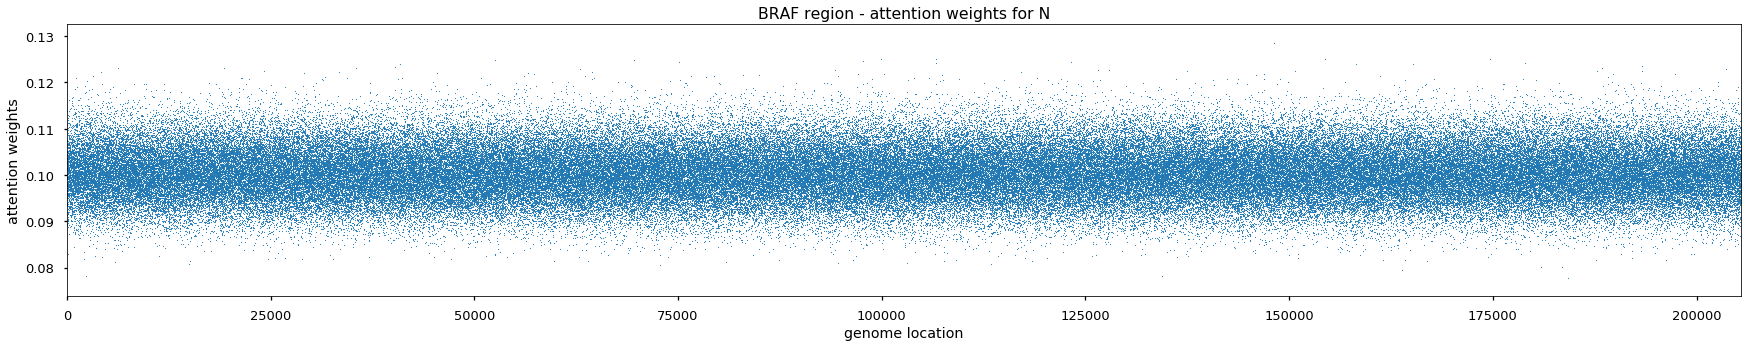

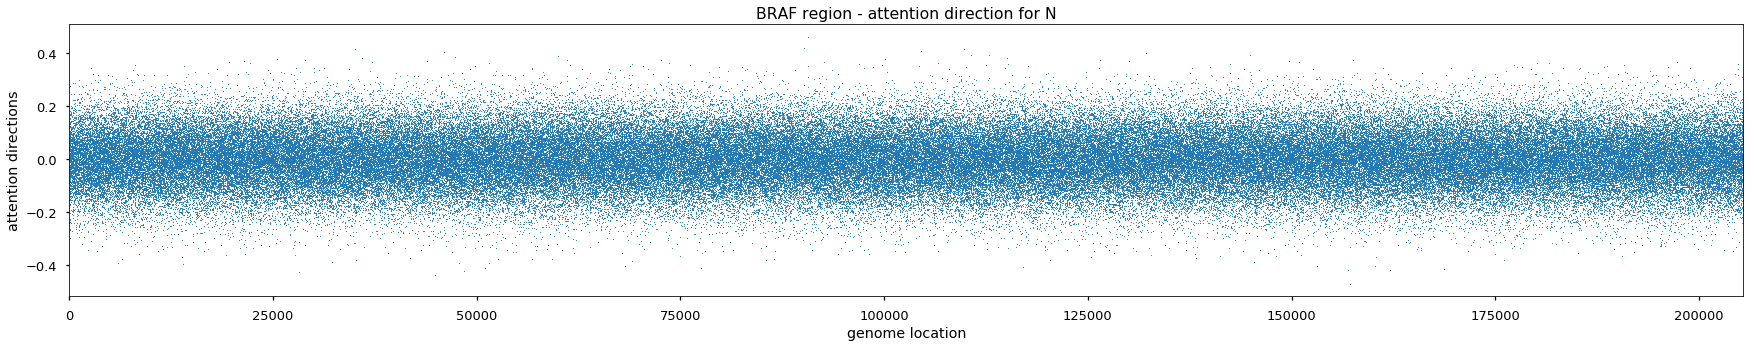

In [81]:
K_lookup_N = model.K(genome_N) 
V_lookup_N = model.V(genome_N) 
logits_N = model.Q(K_lookup_N) / math.sqrt(model.embedding_size)
probs_N = F.softmax(logits_N, dim = -1)    
X_N = probs_N * V_lookup_N

print(probs_N.shape)
print(X_N.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_N.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('BRAF region - attention weights for N')
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_N.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('BRAF region - attention direction for N')
plt.show()


torch.Size([205438, 10])
torch.Size([205438, 10])


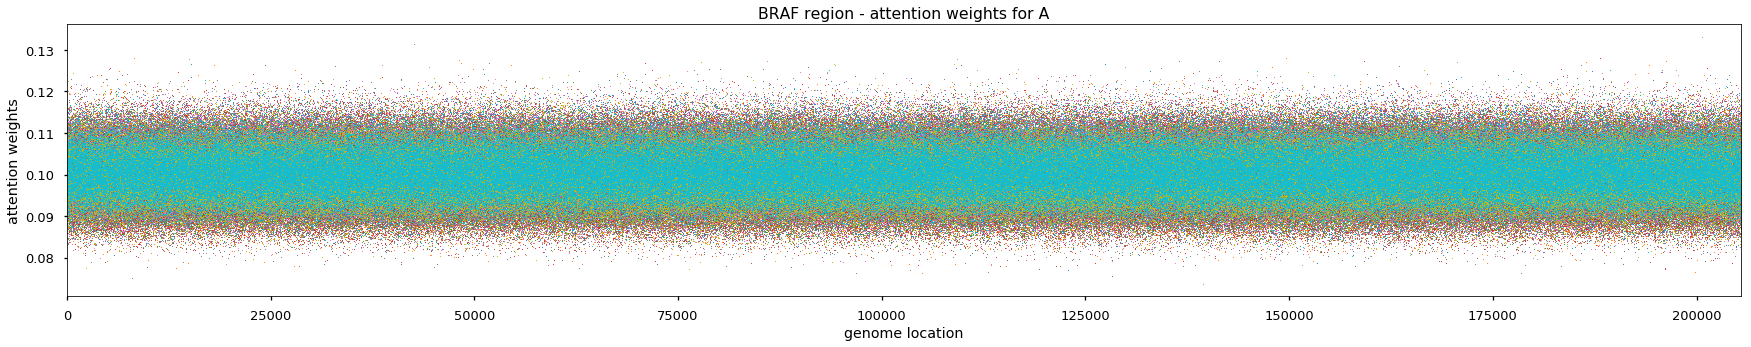

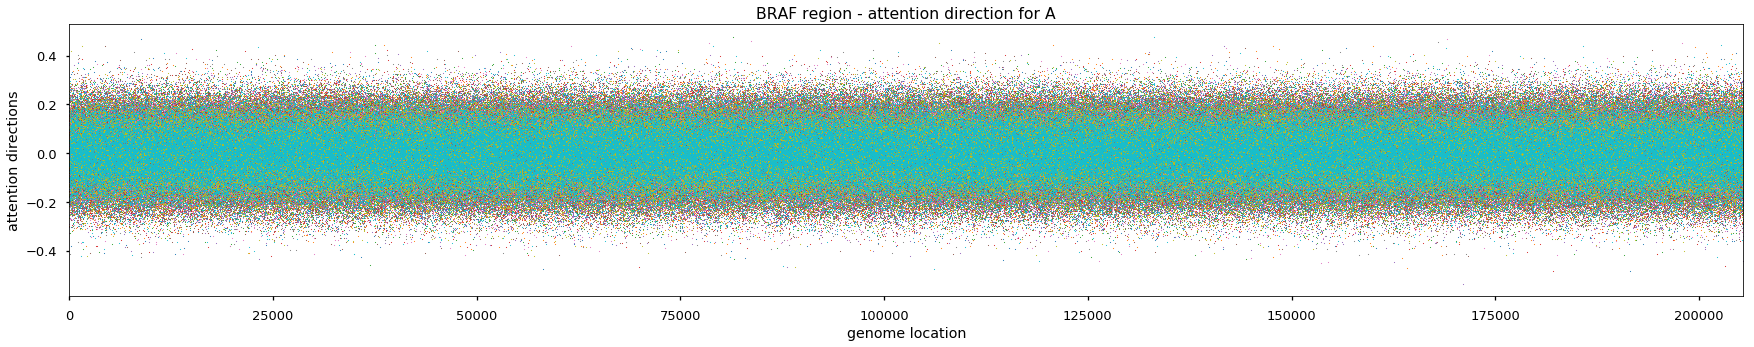

In [87]:
K_lookup_A = model.K(genome_A) 
V_lookup_A = model.V(genome_A) 
logits_A = model.Q(K_lookup_A) / math.sqrt(model.embedding_size)
probs_A = F.softmax(logits_A, dim = -1)    
X_A = probs_A * V_lookup_A

print(probs_A.shape)
print(X_A.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_A.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('BRAF region - attention weights for A')
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_A.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('BRAF region - attention direction for A')
plt.show()


torch.Size([205438, 10])
torch.Size([205438, 10])


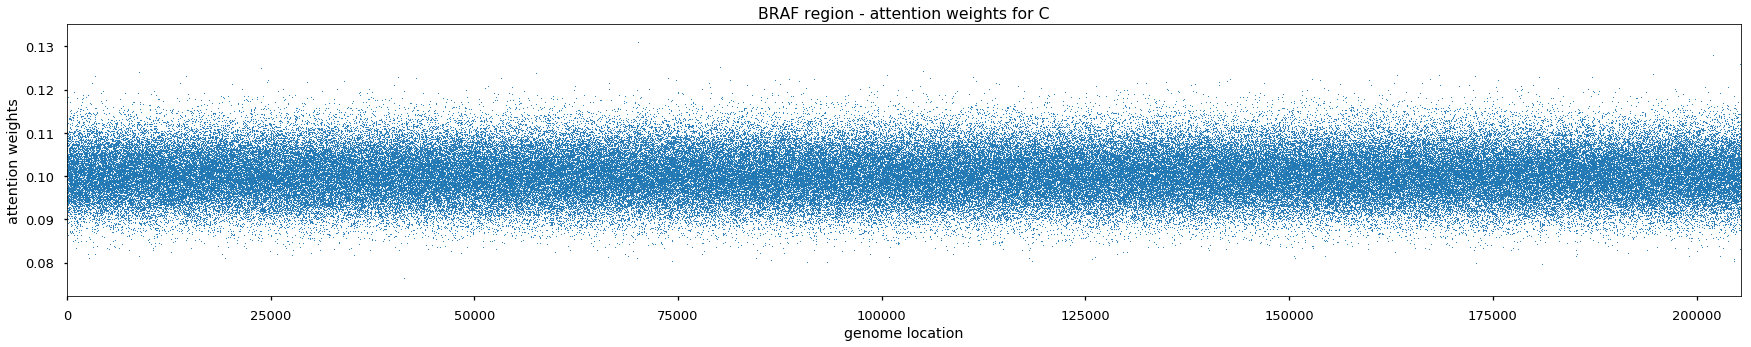

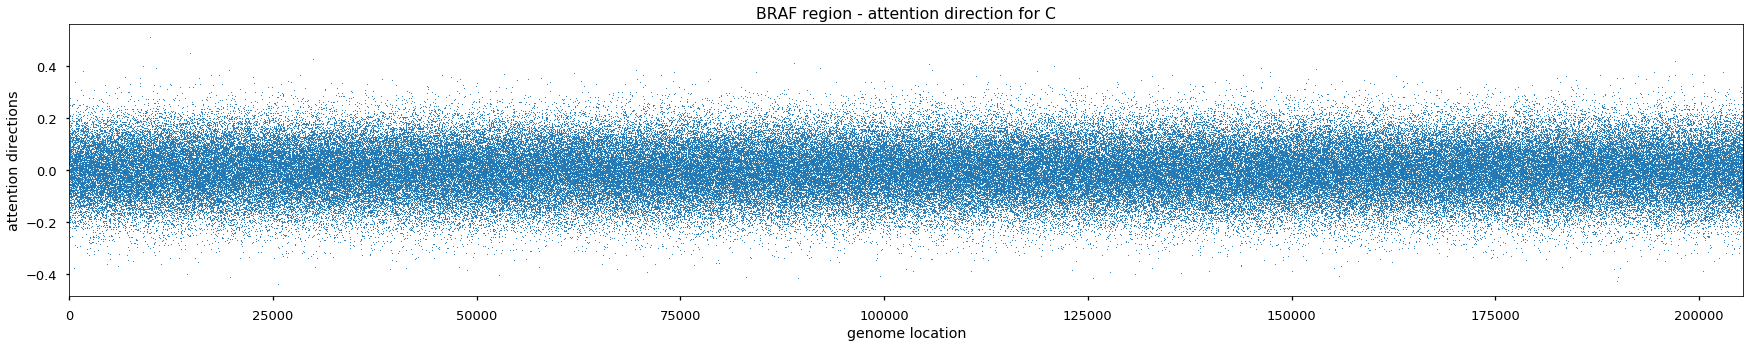

In [83]:
K_lookup_C = model.K(genome_C) 
V_lookup_C = model.V(genome_C) 
logits_C = model.Q(K_lookup_C) / math.sqrt(model.embedding_size)
probs_C = F.softmax(logits_C, dim = -1)    
X_C = probs_C * V_lookup_C

print(probs_C.shape)
print(X_C.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_C.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('BRAF region - attention weights for C')
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_C.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('BRAF region - attention direction for C')
plt.show()


torch.Size([205438, 10])
torch.Size([205438, 10])


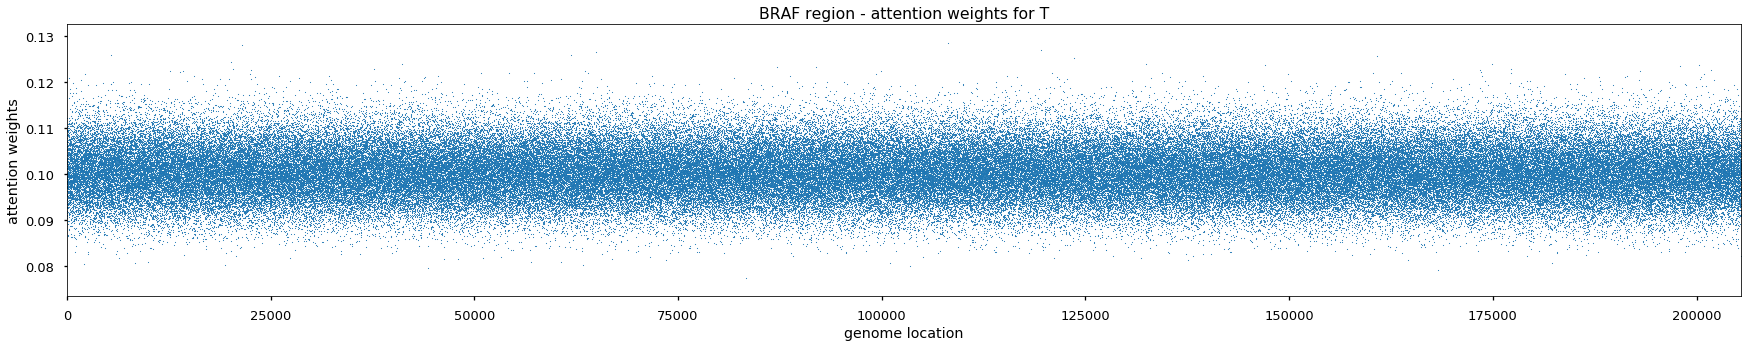

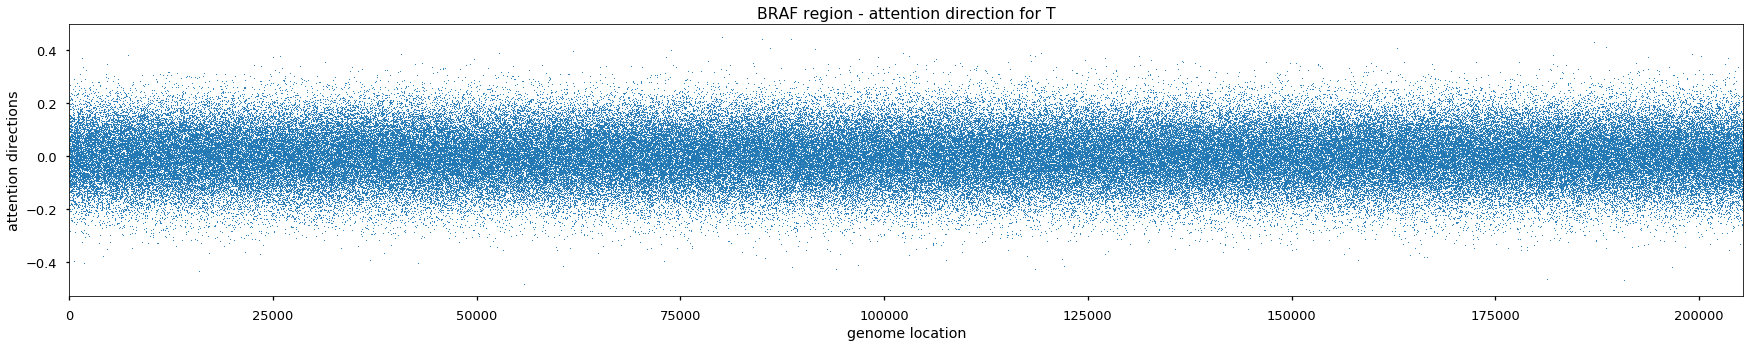

In [84]:
K_lookup_T = model.K(genome_T) 
V_lookup_T = model.V(genome_T) 
logits_T = model.Q(K_lookup_T) / math.sqrt(model.embedding_size)
probs_T = F.softmax(logits_T, dim = -1)    
X_T = probs_T * V_lookup_T

print(probs_T.shape)
print(X_T.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_T.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('BRAF region - attention weights for T')
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_T.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('BRAF region - attention direction for T')
plt.show()


torch.Size([205438, 10])
torch.Size([205438, 10])


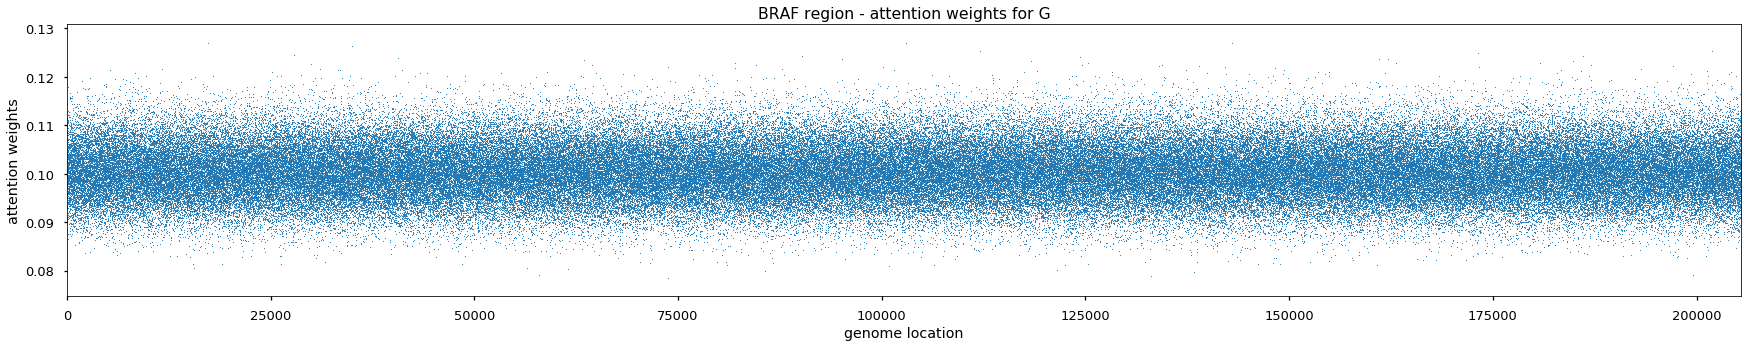

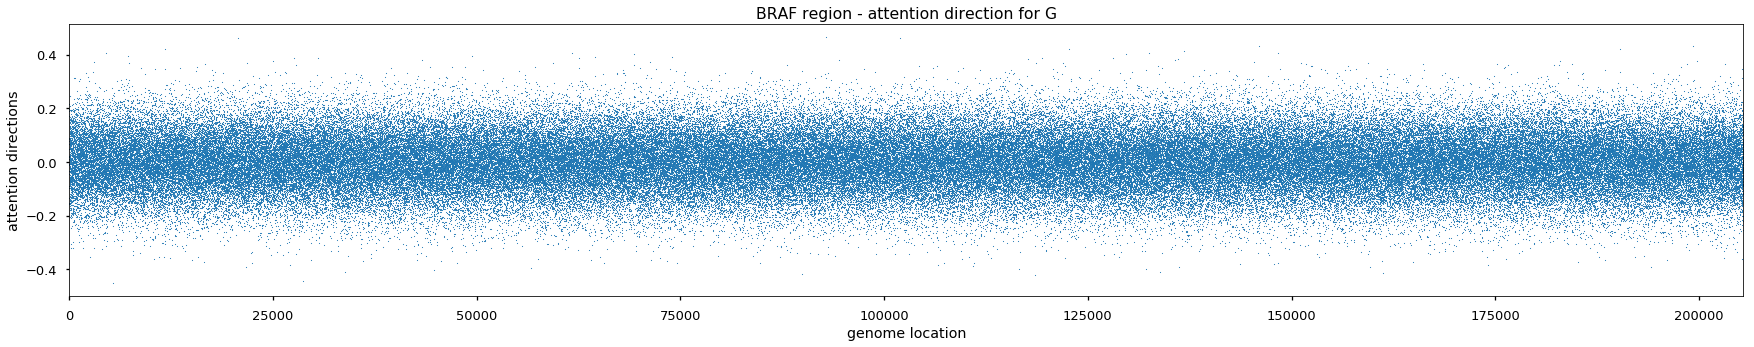

In [85]:
K_lookup_G = model.K(genome_G) 
V_lookup_G = model.V(genome_G) 
logits_G = model.Q(K_lookup_G) / math.sqrt(model.embedding_size)
probs_G = F.softmax(logits_G, dim = -1)    
X_G = probs_G * V_lookup_G

print(probs_G.shape)
print(X_G.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_G.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('BRAF region - attention weights for G')
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_G.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('BRAF region - attention direction for G')
plt.show()
